In [1]:
import datetime

import jpholiday
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import fbprophet.plot as fp
from fbprophet import Prophet
import statsmodels.api as sm
import seaborn as sns
%matplotlib inline

In [3]:
df_train = pd.read_csv('../resource/train.csv')
df_test = pd.read_csv('../resource/test.csv')
df_train.index = pd.to_datetime(df_train['datetime'])
df_test.index = pd.to_datetime(df_test['datetime'])

In [4]:
def isHoliday(DATETIME):
    """指定した日が平日なら0、土日祝日なら1を返す"""
    if type(DATETIME) != 'object':
        DATE = str(DATETIME)
        
    Date = (datetime.datetime.strptime(DATE, '%Y-%m-%d')).date()
    if Date.weekday() >= 5 or jpholiday.is_holiday(Date):
        return 1
    else:
        return 0

In [5]:
df_train['holiday'] = df_train['datetime'].apply(isHoliday)
df_test['holiday'] = df_test['datetime'].apply(isHoliday)

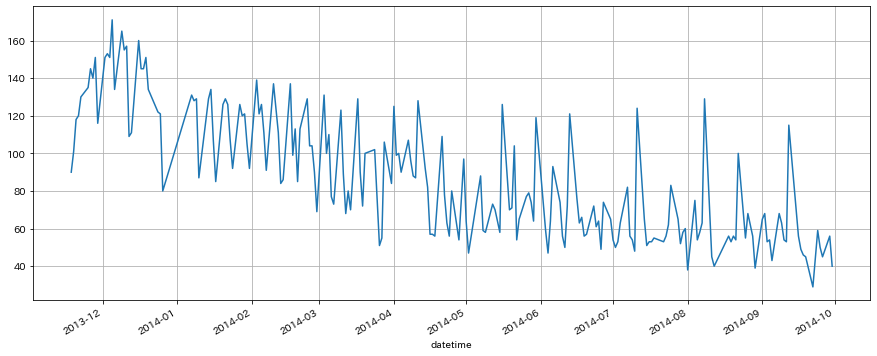

In [6]:
df_train['y'].plot(figsize=(15, 6), grid=True)

In [7]:
res = sm.tsa.seasonal_decompose(df_train['y'], period=5, model='multiplicative')

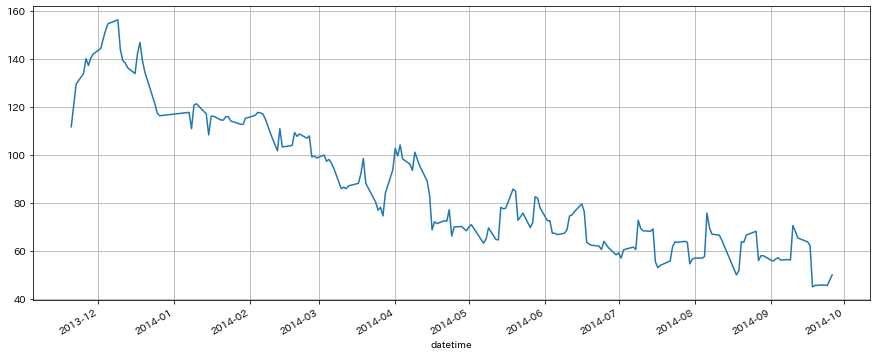

In [8]:
res.trend.plot(figsize=(15, 6), grid=True)

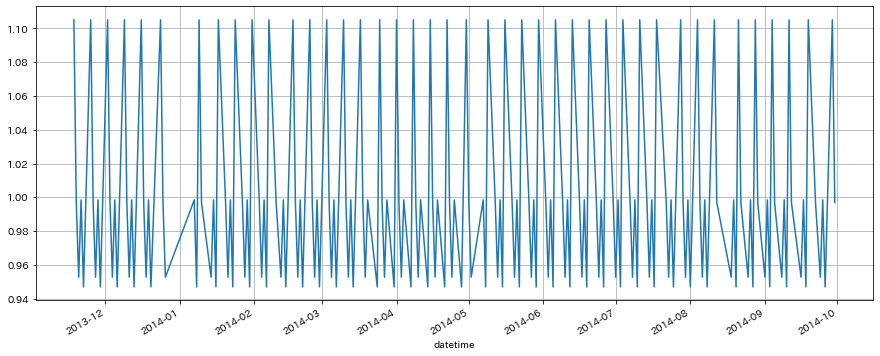

In [9]:
res.seasonal.plot(figsize=(15, 6), grid=True)

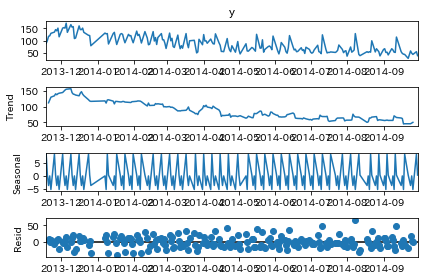

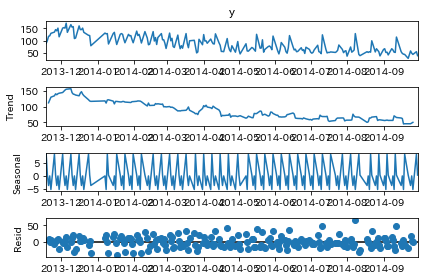

In [12]:
res.plot()

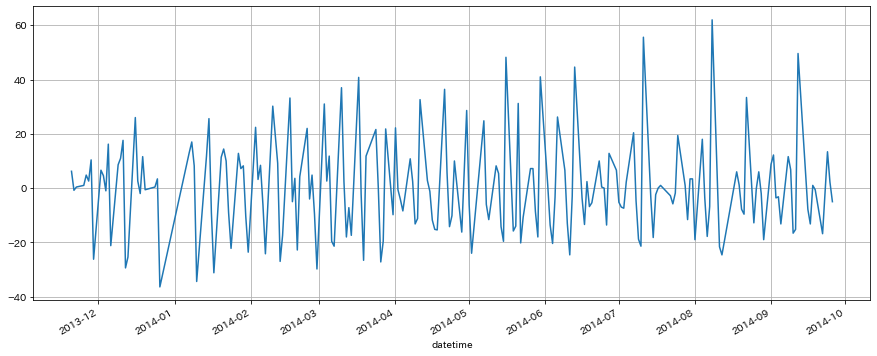

In [10]:
df_train['seasonal'] = df_train['y'] - res.trend
df_train['seasonal'].plot(figsize=(15, 6), grid=True)

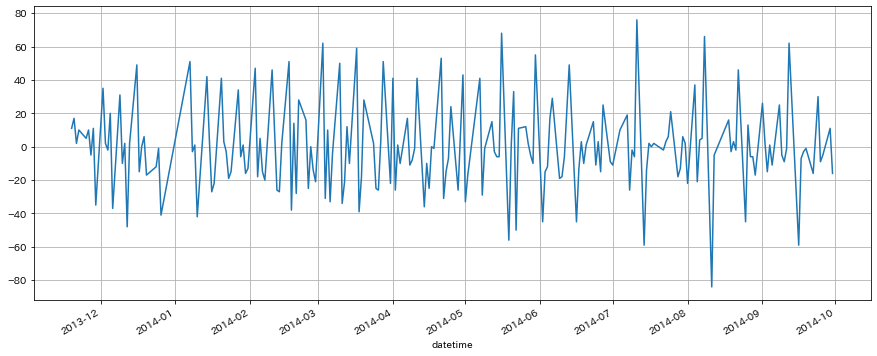

In [19]:
df_train['y'].diff().dropna().plot(figsize=(15, 6), grid=True)

In [20]:
df_train['diff'] = df_train['y'].diff()

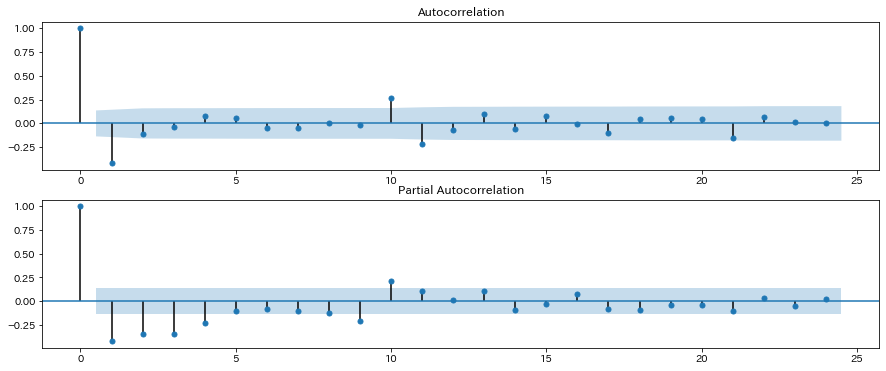

In [23]:
fig = plt.figure(figsize=(15, 6))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_train['diff'].dropna(), ax=ax1, )

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_train['diff'].dropna(), ax=ax2)

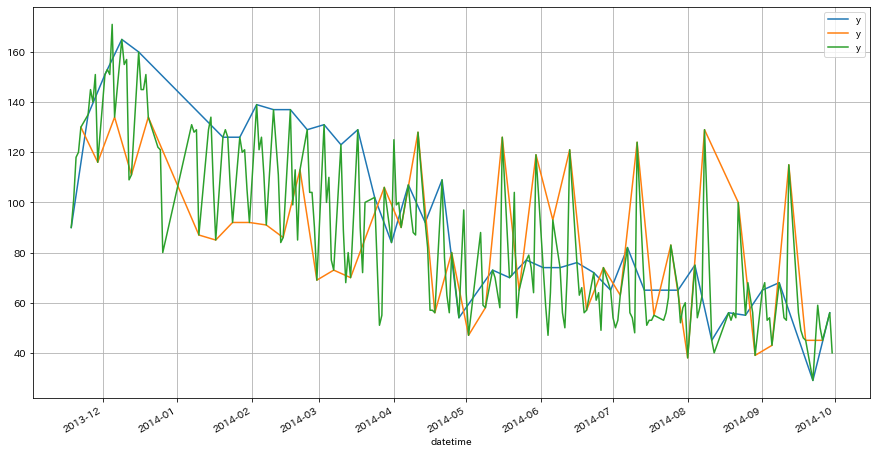

In [33]:
df_train[df_train['week']=='月']['y'].plot(figsize=(15, 8), grid=True)
#df_train[df_train['week']=='火']['y'].plot(figsize=(15, 8), grid=True)
#df_train[df_train['week']=='水']['y'].plot(figsize=(15, 8), grid=True)
#df_train[df_train['week']=='木']['y'].plot(figsize=(15, 8), grid=True)
df_train[df_train['week']=='金']['y'].plot(figsize=(15, 8), grid=True)
df_train['y'].plot(figsize=(15, 8), grid=True)
plt.legend()

In [40]:
df_train['precipitation'].unique()

array(['--', '0.5', '0', '1.5', '1', '6', '6.5', '2.5'], dtype=object)

In [43]:
df_train['precipitation'] = df_train['precipitation'].replace('--', 0)
df_train['precipitation'] = df_train['precipitation'].astype(np.float)

In [44]:
df_train['precipitation']

datetime
2013-11-18    0.0
2013-11-19    0.0
2013-11-20    0.0
2013-11-21    0.0
2013-11-22    0.0
             ... 
2014-09-24    0.0
2014-09-25    0.0
2014-09-26    0.0
2014-09-29    0.0
2014-09-30    0.0
Name: precipitation, Length: 207, dtype: float64

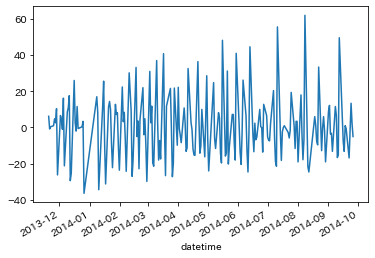

In [51]:
df_train['seasonal'].plot()

In [18]:
df_train = df_train.rename(columns = {'datetime':'ds'})
df_test = df_test.rename(columns = {'datetime':'ds'})
df_event = df_train[df_train['remarks']=='お楽しみメニュー'].loc[:,['ds', 'remarks']]
df_event = pd.concat([df_train[df_train['remarks']=='お楽しみメニュー'].loc[:,['ds', 'remarks']], df_test[df_test['remarks']=='お楽しみメニュー'].loc[:,['ds', 'remarks']]])

df_event = df_event.rename(columns = {'remarks':'holiday'})
df_event['lower_window'] = 0
df_event['upper_window'] = 0
df_event.reset_index()

,datetime,ds,holiday,lower_window,upper_window
0,2014-03-28,2014-3-28,お楽しみメニュー,0,0
1,2014-04-11,2014-4-11,お楽しみメニュー,0,0
2,2014-04-25,2014-4-25,お楽しみメニュー,0,0
3,2014-05-16,2014-5-16,お楽しみメニュー,0,0
4,2014-05-30,2014-5-30,お楽しみメニュー,0,0
5,2014-06-13,2014-6-13,お楽しみメニュー,0,0
6,2014-06-27,2014-6-27,お楽しみメニュー,0,0
7,2014-07-11,2014-7-11,お楽しみメニュー,0,0
8,2014-07-25,2014-7-25,お楽しみメニュー,0,0
9,2014-08-08,2014-8-8,お楽しみメニュー,0,0


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


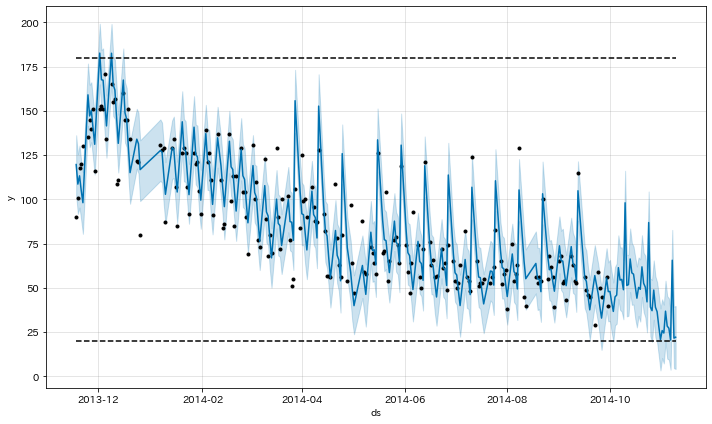

In [61]:
# prophet
model = Prophet(growth='logistic', seasonality_mode='multiplicative', 
                weekly_seasonality=True, yearly_seasonality=True,
                holidays=df_event, #holidays_prior_scale=10,
                #mcmc_samples=100, 
                #changepoint_prior_scale=1.0
                )


df_train['cap'] = 180
df_train['floor'] = 20
model.fit(df_train)
future_df = model.make_future_dataframe(40, freq='D')
future_df['cap'] = 180
future_df['floor'] = 20
forecast_df = model.predict(future_df)

model.plot(forecast_df)
plt.show()
#fig = model.plot(forecast_df)
#a = fp.add_changepoints_to_plot(fig.gca(),model,forecast_df);

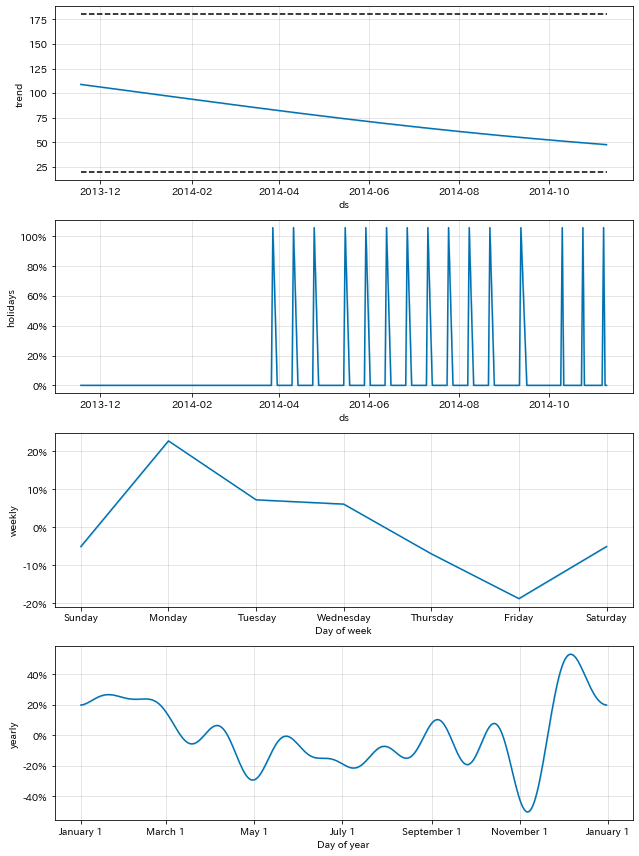

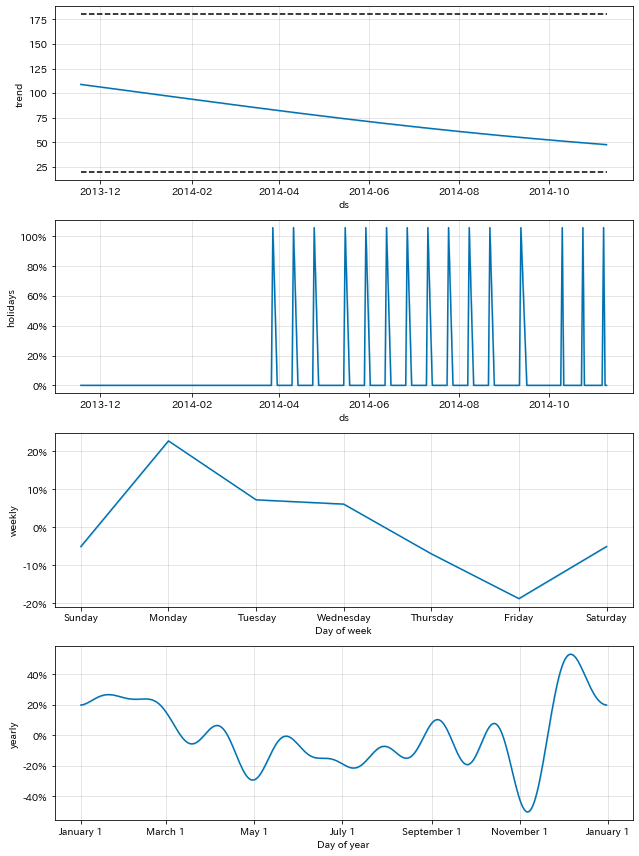

In [24]:
model.plot_components(forecast_df)

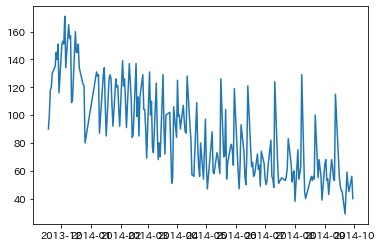

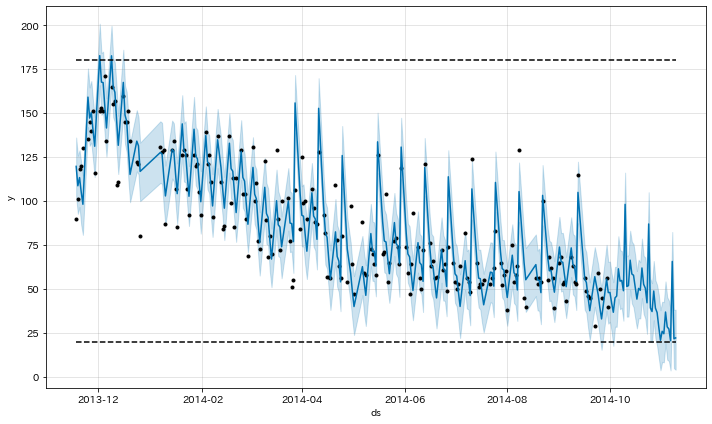

In [130]:
plt.plot(df_train['y'])
model.plot(forecast_df)
plt.show()

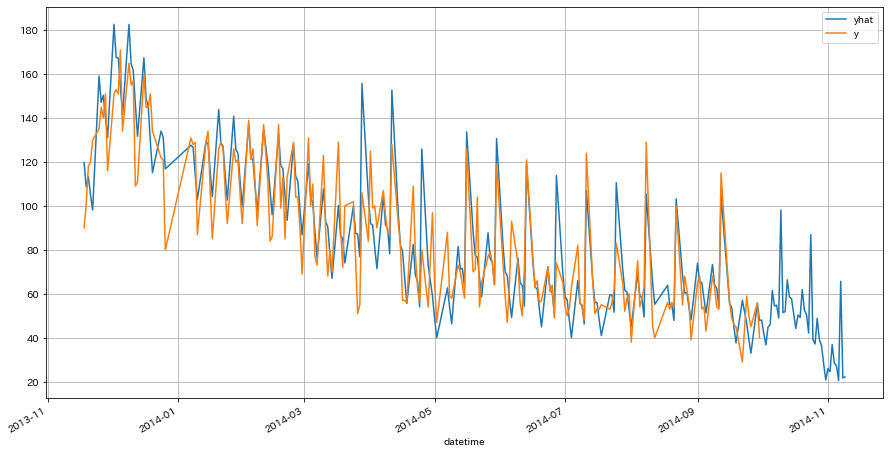

In [109]:
forecast_df.index = pd.to_datetime(forecast_df['ds'])
forecast_df['yhat'].plot(figsize=(15, 8), grid=True)
df_train['y'].plot(figsize=(15, 8), grid=True)
plt.legend()

In [75]:
y_pred = forecast_df.loc[207:, 'yhat'].values
y_pred

array([48.01475646, 41.97154306, 36.73626521, 44.91639266, 45.96782849,
       61.47283072, 54.44508899, 54.8361626 , 48.98402179, 98.12139669,
       51.40768283, 51.88619357, 66.36931883, 58.51633731, 57.78623418,
       50.772887  , 44.20857566, 50.30326436, 49.24415792, 61.92694584,
       52.66321521, 50.44585268, 42.13046895, 86.94506284, 39.19122313,
       37.1519258 , 48.81613662, 39.11975424, 36.5812097 , 28.28969576,
       20.78993038, 25.9142557 , 24.53800976, 36.87257961, 28.43081775,
       27.23336435, 20.56474685, 65.65755149, 21.64796049, 22.1711001 ])

In [78]:
sample = pd.read_csv('../output/sample.csv')
sample[1] = y_pred
sample.to_csv('../output/submit.csv', index=None, header=None)

In [77]:
sample

,0,1
0,2014-10-1,48.014756
1,2014-10-2,41.971543
2,2014-10-3,36.736265
3,2014-10-6,44.916393
4,2014-10-7,45.967828
5,2014-10-8,61.472831
6,2014-10-9,54.445089
7,2014-10-10,54.836163
8,2014-10-14,48.984022
9,2014-10-15,98.121397
